In [3]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random
import glob
import matplotlib.gridspec as gs


In [4]:
from dask.distributed import Client, LocalCluster
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43441 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43441/status,
Dashboard: /proxy/43441/status,Workers: 4
Total threads: 8,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43119,Workers: 4
Dashboard: /proxy/43441/status,Total threads: 8
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:39123,Total threads: 2
Dashboard: /proxy/33625/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:41803,


In [5]:
#move the longitudes from 0-360 to -180-180
def roll_lon(df):
    df.coords['longitude'] = (df.coords['longitude'] + 180) % 360 - 180
    df = df.sortby(df.longitude)
    return df

In [6]:
data_dir = "/g/data/e14/sm2435/Pascal_runs/Pacemakers/"

In [7]:
#load in LSM
LSM = xr.open_dataset(data_dir+"echam_mesh_mask_oce.nc").nmask.rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')[::-1]


In [8]:
ctrl = xr.open_dataset(data_dir+"REFADA_1m_000101_021012_tsurf.nc", use_cftime=True).tsurf.rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')
ctrl = ctrl.where(LSM==1)
ctrl = roll_lon(ctrl)

In [9]:
ctrl_u = xr.open_dataset(data_dir+"REFADA_1m_000101_021012_u10.nc", use_cftime=True).u10.rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')
ctrl_u = ctrl_u.where(LSM==1)
ctrl_u = roll_lon(ctrl_u)

In [10]:
ctrl_v = xr.open_dataset(data_dir+"REFADA_1m_000101_021012_v10.nc", use_cftime=True).v10.rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')
ctrl_v = ctrl_v.where(LSM==1)
ctrl_v = roll_lon(ctrl_v)

In [11]:
ctrl_z20 = xr.open_dataset(data_dir+"REFADA_1m_000101_021012_20d.nc", use_cftime=True)['20d'].rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')
ctrl_z20 = ctrl_z20.where(LSM==1)
ctrl_z20 = roll_lon(ctrl_z20)

In [12]:
FTP = xr.open_dataset(data_dir+"FTP_1m_000101_005012_tsurf.nc", use_cftime=True).tsurf.rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')
FTP = FTP.where(LSM==1)
FTP = roll_lon(FTP)
###obs climatology

In [13]:
FTP_u = xr.open_dataset(data_dir+"FTP_1m_000101_005012_u10.nc", use_cftime=True).u10.rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')
FTP_u = FTP_u.where(LSM==1)
FTP_u = roll_lon(FTP_u)

In [14]:
FTP_v = xr.open_dataset(data_dir+"FTP_1m_000101_005012_v10.nc", use_cftime=True).v10.rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')
FTP_v = FTP_v.where(LSM==1)
FTP_v = roll_lon(FTP_v)

In [15]:
FTP_z20 = xr.open_dataset(data_dir+"FTP_1m_000101_005012_20d.nc", use_cftime=True)['20d'].rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')
FTP_z20 = FTP_z20.where(LSM==1)
FTP_z20 = roll_lon(FTP_z20)

In [16]:
FTPC = xr.open_dataset(data_dir+"FTPC_1m_000101_011012_tsurf.nc", use_cftime=True).tsurf.rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')
FTPC = FTPC.where(LSM==1)
FTPC = roll_lon(FTPC)
###model climatology

In [17]:
FTPC_u = xr.open_dataset(data_dir+"FTPC_1m_000101_011012_u10.nc", use_cftime=True).u10.rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')
FTPC_u = FTPC_u.where(LSM==1)
FTPC_u = roll_lon(FTPC_u)

In [18]:
FTPC_v = xr.open_dataset(data_dir+"FTPC_1m_000101_011012_v10.nc", use_cftime=True).v10.rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')
FTPC_v = FTPC_v.where(LSM==1)
FTPC_v = roll_lon(FTPC_v)

In [19]:
FTPC_z20 = xr.open_dataset(data_dir+"FTPC_1m_000101_011012_20d.nc", use_cftime=True)['20d'].rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')
FTPC_z20 = FTPC_z20.where(LSM==1)
FTPC_z20 = roll_lon(FTPC_z20)

In [20]:
#now write a fucntion to output bias and to optioanlly plot
def plot_bias(exp, ctrl, exp_u, exp_v, ref_u, ref_v, freq=None, temp_scale = 2):
    #check frequency of sampling, defaukt to monthly if not specified
    if freq == None:
        freq = 'monthly'
    #check what the obs file is time or month already
    if ctrl.dims[0] == "time":
        ctrl_mon = ctrl.groupby('time.month').mean('time')
        ctrl_mn = ctrl.mean('time')
    else:
        ctrl_mon = ctrl 
        ctrl_mn = ctrl.mean('month')
    #calculate the bias
    if freq == "monthly":
        bias = (exp.groupby('time.month').mean('time') - ctrl_mon)
        #get wind  climatologies
        # Ref dataset
        ref_str = np.sqrt(ref_u**2+ref_v**2)
        ref_u = ref_u.groupby('time.month').mean('time')
        ref_v = ref_v.groupby('time.month').mean('time')
        ref_spd = ref_str.groupby('time.month').mean('time')
        # Exp dataset
        exp_str = np.sqrt(exp_u**2+exp_v**2)
        exp_u = exp_u.groupby('time.month').mean('time')
        exp_v = exp_v.groupby('time.month').mean('time')
        exp_spd = exp_str.groupby('time.month').mean('time')  
        #Now get bias
        u_bias = exp_u - ref_u
        v_bias = exp_v - ref_v
        spd_bias = exp_spd - ref_spd
        fg = bias.plot.contourf(col='month', col_wrap = 4,  transform=ccrs.PlateCarree(),
                             subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180)}, 
                              figsize=(20,8), vmin = -1*temp_scale, vmax = temp_scale, levels =10, extend = 'both',  cmap = 'RdBu_r',
                                cbar_kwargs=dict(label='Depth bias ($m$)'))
        for i, ax in enumerate(fg.axs.flat):
            if i ==0:
                Q = ax.quiver(u_bias.longitude[::10].values, u_bias.latitude[::10].values, u_bias[i, ::10,::10].values, v_bias[i, ::10,::10].values, 
                          transform=ccrs.PlateCarree(), scale = 1, scale_units = 'width', width = 0.0015, headwidth=5)
            else:
                ax.quiver(u_bias.longitude[::10].values, u_bias.latitude[::10].values, u_bias[i, ::10,::10].values, v_bias[i, ::10,::10].values, 
                          transform=ccrs.PlateCarree(), scale = 1, scale_units = 'width', width = 0.0015, headwidth=5)
            ax.coastlines()
            #ax.set_facecolor('grey')
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

            if i in [0,1,2,3,4,5,6,7]:
                gl.bottom_labels = False
            if i in [1,2,3,5,6,7,9,10,11]:
                gl.left_labels = False
            gl.top_labels = False
            gl.right_labels = False               
        qk = ax.quiverkey(Q, 1, 1.1, 0.05, r'$0.05 \frac{N}{m^2}$', labelpos='E',
                   coordinates='axes')
        #now add the month labels\n",
        titles =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul',
                 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        for ax,title in zip(fg.axs.flatten(),titles):
            ax.set_title(title )
            ax.axhline(y=-15, color='black', linestyle='--', linewidth=1)  # 15S
            ax.axhline(y=15, color='black', linestyle='--', linewidth=1)
        return

    elif freq == "season":
        bias = (exp.groupby('time.season').mean('time') - ctrl.groupby('time.season').mean('time'))
        #get wind  climatologies
        # Ref dataset
        ref_str = np.sqrt(ref_u**2+ref_v**2)
        ref_u = ref_u.groupby('time.season').mean('time')
        ref_v = ref_v.groupby('time.season').mean('time')
        ref_spd = ref_str.groupby('time.season').mean('time')
        # Exp dataset
        exp_str = np.sqrt(exp_u**2+exp_v**2)
        exp_u = exp_u.groupby('time.season').mean('time')
        exp_v = exp_v.groupby('time.season').mean('time')
        exp_spd = exp_str.groupby('time.season').mean('time')  
        #Now get bias
        u_bias = exp_u - ref_u
        v_bias = exp_v - ref_v
        spd_bias = exp_spd - ref_spd
        fg = bias.plot.contourf(col='season', col_wrap = 2,  transform=ccrs.PlateCarree(),
                             subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180)}, 
                              figsize=(20,8), vmin = -1*temp_scale, vmax = temp_scale, levels =10, extend = 'both',  cmap = 'RdBu_r',
                                cbar_kwargs=dict(label='Depth bias ($m$)'))
        for i, ax in enumerate(fg.axs.flat):
            #if i ==0:
             #   Q = ax.quiver(u_bias.longitude[::8].values, u_bias.latitude[::4].values, u_bias[i, ::4,::8].values, v_bias[i, ::4,::8].values, 
             #             transform=ccrs.PlateCarree(), scale = 1, scale_units = 'width', width = 0.001, headwidth=5)
            #else:
            #    ax.quiver(u_bias.longitude[::8].values, u_bias.latitude[::4].values, u_bias[i, ::4,::8].values, v_bias[i, ::4,::8].values, 
            #              transform=ccrs.PlateCarree(), scale = 1, scale_units = 'width', width = 0.001, headwidth=5)

            ax.coastlines()
            #ax.set_facecolor('grey')
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

            if i in [0,1]:
                gl.bottom_labels = False
            if i in [1,3]:
                gl.left_labels = False
            gl.top_labels = False
            gl.right_labels = False               
        #qk = ax.quiverkey(Q, 1., 1.05, 0.05, r'$0.05 \frac{N}{m^2}$', labelpos='E',
        #           coordinates='axes')
        #now add the month labels\n",
        titles =['DJF', 'MAM', 'JJA', 'SON']
        for ax,title in zip(fg.axs.flatten(),titles):
            ax.set_title(title )
            ax.axhline(y=-15, color='black', linestyle='--', linewidth=1)  # 15S
            ax.axhline(y=15, color='black', linestyle='--', linewidth=1)
        return

    elif freq == "annual":
        bias = (exp.mean('time') - ctrl_mn)
        # Ref dataset
        ref_str = np.sqrt(ref_u**2+ref_v**2)
        ref_u = ref_u.mean('time')
        ref_v = ref_v.mean('time')
        ref_spd = ref_str.mean('time')
        # Exp dataset
        exp_str = np.sqrt(exp_u**2+exp_v**2)
        exp_u = exp_u.mean('time')
        exp_v = exp_v.mean('time')
        exp_spd = exp_str.mean('time')  
        #Now get bias
        u_bias = exp_u - ref_u
        v_bias = exp_v - ref_v
        spd_bias = exp_spd - ref_spd
        # Now plot figure
        plt.figure(figsize = (12,8))
        ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
        bias.plot.contourf(ax=ax, vmin = -1*temp_scale, vmax = temp_scale, cmap = "RdBu_r", levels = 10, extend = 'both',
               transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='Depth bias ($m$)'))

        #Q = ax.quiver(u_bias.longitude[::10].values, u_bias.latitude[::5].values,
        #              u_bias[::5,::10].values, v_bias[::5,::10].values, 
        #          transform=ccrs.PlateCarree(), scale = 1, scale_units = 'width', width = 0.0015, headlength=3)

        #ax.set_title('Annual mean SST bias')
        ax.coastlines(color = 'k')
        ax.axhline(y=-15, color='black', linestyle='--', linewidth=1)  # 15S
        ax.axhline(y=15, color='black', linestyle='--', linewidth=1)
        ax.gridlines()
        #ax.set_facecolor('grey')
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        #qk = ax.quiverkey(Q, 0.9, 1.1, 0.05, r'$0.05 \frac{N}{m^2}$', labelpos='E',
        #           coordinates='axes')
        return 


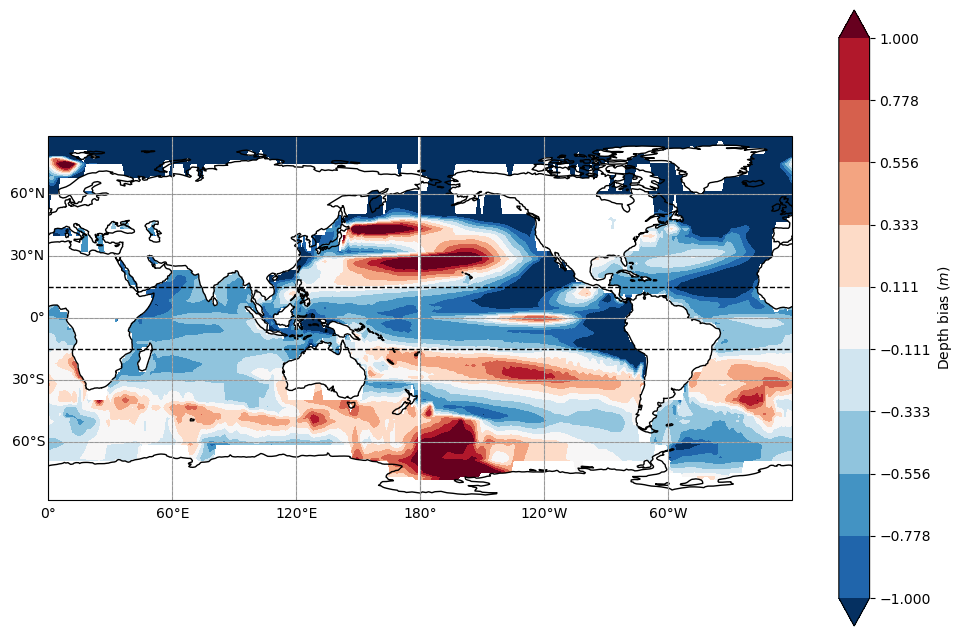

In [21]:
plot_bias(FTP, ctrl, FTP_u, FTP_v, ctrl_u, ctrl_v, freq="annual", temp_scale = 1)

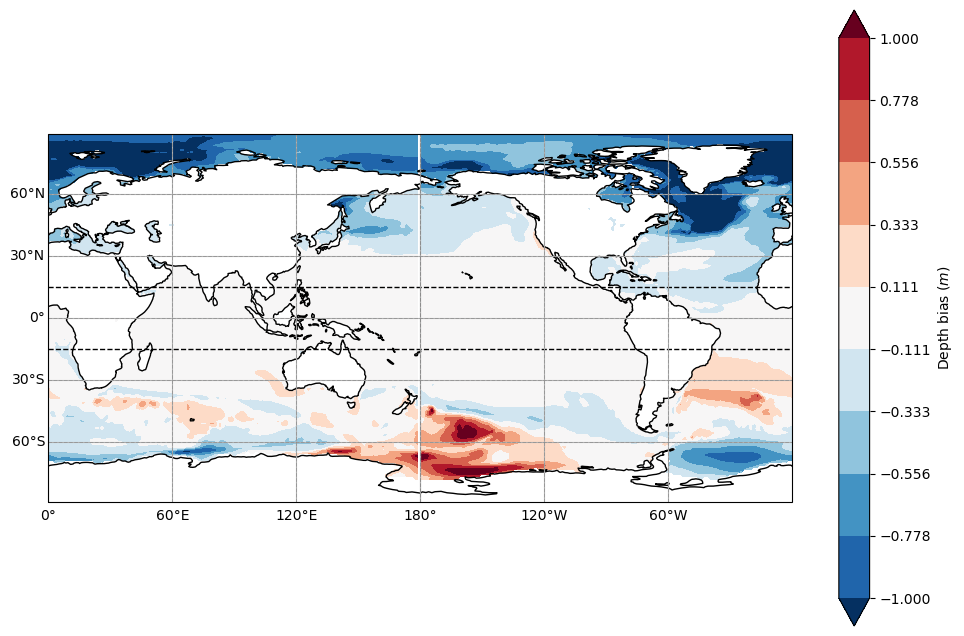

In [22]:
plot_bias(FTPC, ctrl, FTPC_u, FTPC_v, ctrl_u, ctrl_v, freq="annual", temp_scale = 1)

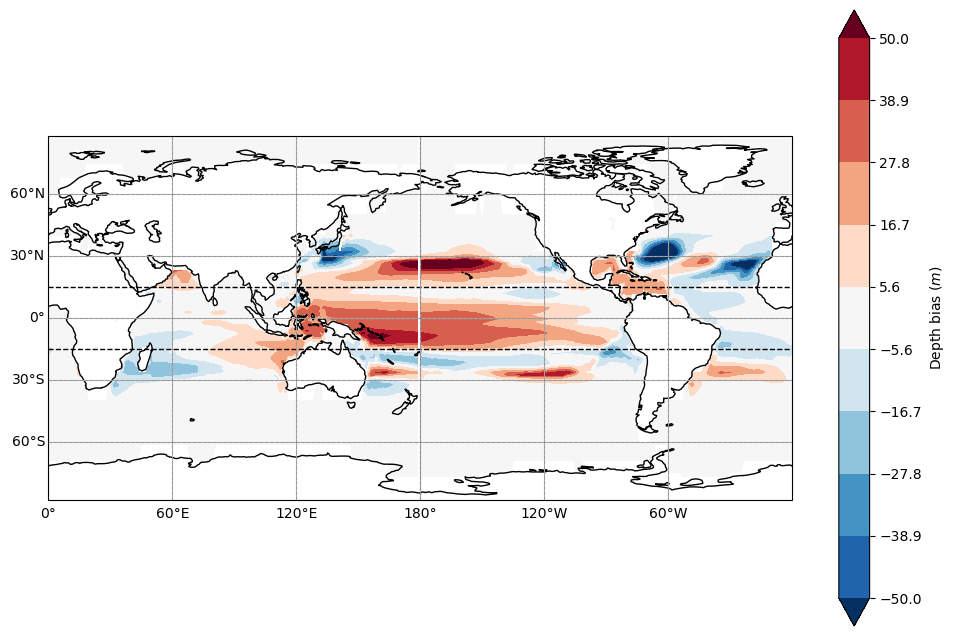

In [24]:
plot_bias(FTP_z20, ctrl_z20, FTP_u, FTP_v, ctrl_u, ctrl_v, freq="annual", temp_scale = 50)

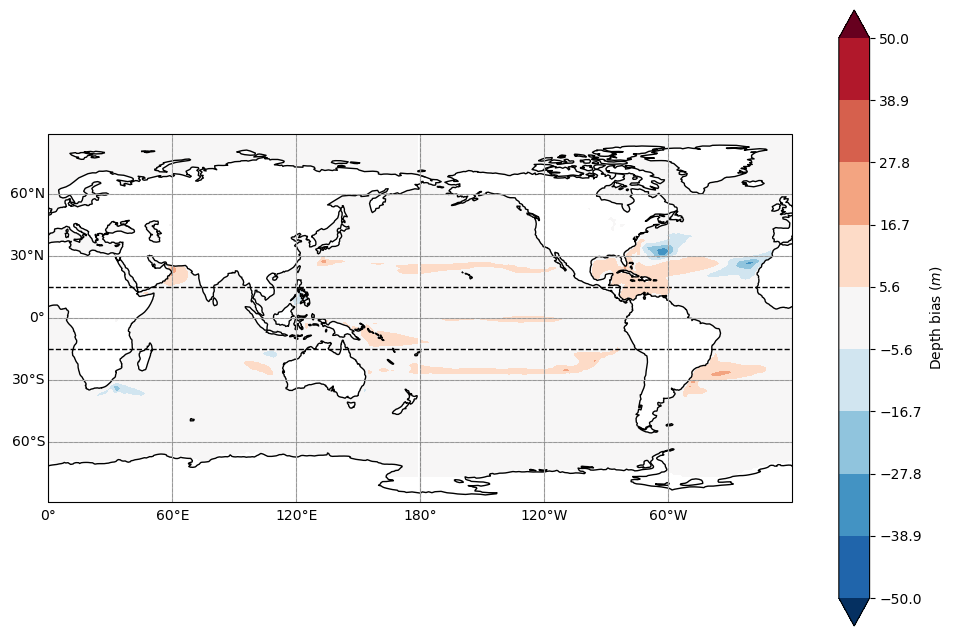

In [26]:
plot_bias(FTPC_z20, ctrl_z20, FTP_u, FTP_v, ctrl_u, ctrl_v, freq="annual", temp_scale = 50)

In [23]:
ctrl_z20 = ctrl_z20.rename({'time_counter': 'time'})
FTP_z20 = FTP_z20.rename({'time_counter': 'time'})
FTPC_z20 = FTPC_z20.rename({'time_counter': 'time'})

In [67]:
u_bias = FTP_u.mean("time") - ctrl_u.mean("time")
v_bias = FTP_v.mean("time") - ctrl_v.mean("time")


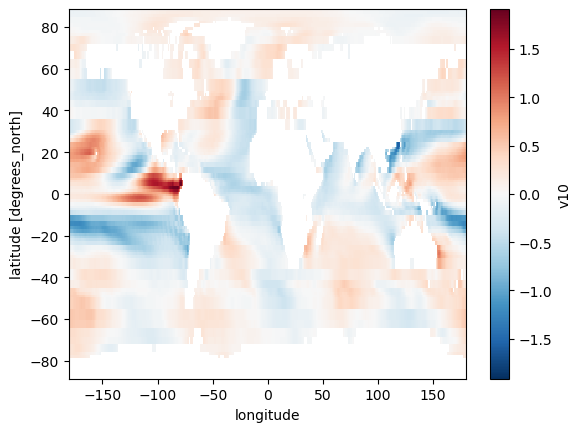

In [68]:
v_bias.plot()

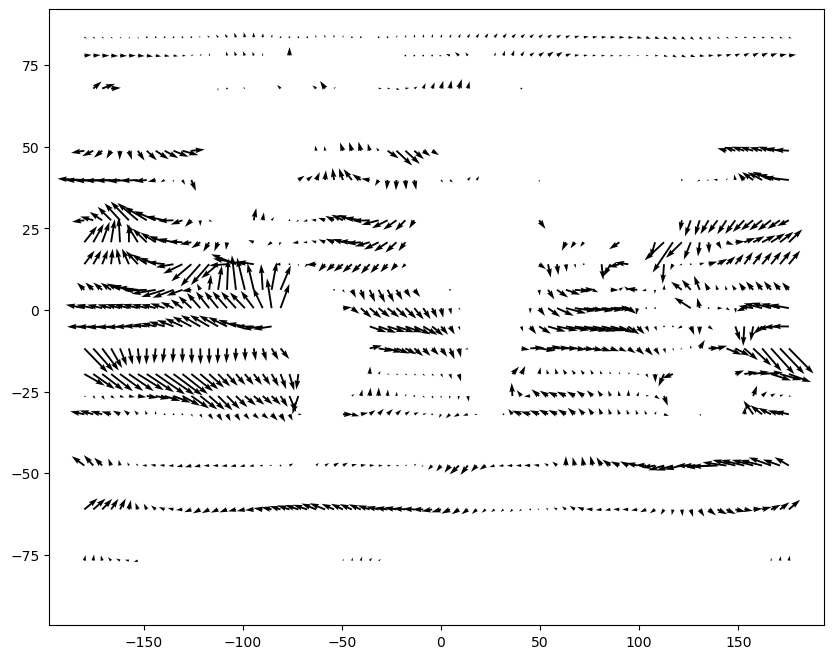

In [74]:
plt.figure(figsize=(10,8))
plt.quiver(u_bias.longitude.values[::4], u_bias.latitude.values[::4],
                      u_bias.values[::4,::4], v_bias.values[::4,::4],)
           #scale = 50, scale_units = 'width', width = 0.0015, headlength=3)